# Import Library

Ini adalah library yang dibutuhkan selama proses pelatihan model

In [17]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from transformers import MarianMTModel, MarianTokenizer, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import logging
from datetime import datetime
from tqdm import tqdm
import warnings
import random
warnings.filterwarnings('ignore')

Wikipedia serves as a primary source of medical information 
for millions of users worldwide. However, the open-edit nature of the platform 
raises concerns about article quality, particularly for critical health topics.

**Objective:** This study develops an automated quality assessment system for 
Wikipedia medical articles using BioBERT, a domain-specific pre-trained 
language model, enhanced with advanced text augmentation techniques to address 
severe class imbalance.

**Methods:** We fine-tuned BioBERT on 51,890 medical articles from Wikipedia's 
Medicine Portal, labeled across six quality classes (Stub, Start, C, B, GA, FA). 
To mitigate extreme class imbalance (FA: 0.2%, GA: 0.8%), we implemented:
1. Contextual augmentation using masked language modeling
2. Back-translation through French and German
3. Class-weighted loss functions

**Results:** The proposed model achieved a macro F1-score of 0.65 and weighted 
ROC-AUC of 0.86, significantly outperforming baseline approaches (F1: 0.40). 
Notably, performance on minority classes improved dramatically: FA F1-score 
increased from 0.00 to 0.45, and GA from 0.17 to 0.58.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

def load_dataset_statistics(dataset_path="final_dataset_fix.jsonl"):
    """Load dataset and display comprehensive statistics from real JSONL dataset"""
    
    # === 1. Load JSONL file ===
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset file not found: {dataset_path}")
    
    records = []
    with open(dataset_path, "r", encoding="utf-8") as f:
        for line in f:
            records.append(json.loads(line))
    
    df_raw = pd.DataFrame(records)
    
    if 'label' not in df_raw.columns:
        raise ValueError("Column 'label' not found in dataset. Please check your JSONL structure.")
    
    # === 2. Compute statistics ===
    class_counts = df_raw['label'].value_counts().sort_index()
    df_stats = pd.DataFrame({
        'Class': class_counts.index,
        'Count': class_counts.values
    })
    df_stats['Percentage'] = (df_stats['Count'] / df_stats['Count'].sum() * 100).round(2)
    df_stats['Imbalance Ratio'] = (df_stats['Count'].max() / df_stats['Count']).round(1)
    
    # === 3. Print summary ===
    print("="*70)
    print("DATASET STATISTICS")
    print("="*70)
    print(df_stats.to_string(index=False))
    print("="*70)
    print(f"Total Articles: {df_stats['Count'].sum():,}")
    print(f"Max Imbalance Ratio: {df_stats['Imbalance Ratio'].max():.1f}:1")
    print("="*70)
    
    # === 4. Visualization ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = sns.color_palette("husl", len(df_stats))
    
    # Bar plot
    axes[0].bar(df_stats['Class'], df_stats['Count'], color=colors)
    axes[0].set_xlabel('Quality Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Articles', fontsize=12, fontweight='bold')
    axes[0].set_title('Class Distribution (Original Dataset)', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(df_stats['Count']):
        axes[0].text(i, v + (0.01 * df_stats['Count'].max()), 
                     f"{v:,}\n({df_stats['Percentage'].iloc[i]}%)", 
                     ha='center', va='bottom', fontsize=9)
    
    # Pie chart
    axes[1].pie(df_stats['Count'], labels=df_stats['Class'], autopct='%1.1f%%', 
                startangle=90, colors=colors)
    axes[1].set_title('Percentage Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    os.makedirs('outputs', exist_ok=True)
    plt.savefig('outputs/class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_stats


# === Execute ===
dataset_stats = load_dataset_statistics("final_dataset_fix.jsonl")


ValueError: Column 'label' not found in dataset. Please check your JSONL structure.

https://arxiv.org/pdf/1603.01987
https://arxiv.org/pdf/2310.02235

# Configuration

In this configuration, we implement these mechanism to ensure comprehensive tracking of the training process. There are :
- File Handler (training.log): For persistent storage of all training events
- Stream Handler (Console): Real-time monitoring during training
- Base Model Selection : We use BioBERT-Base v1.1, a Pre-trained BERT on 4.5B words from PubMed abstracts and 13.5B words from PMC full-text articles with  110M parameters provide strong performance without excessive computational cost
- Maximum Sequence Length: 512 tokens which is a BERT standard maximum positional encoding limit
- Training Hyperparameters : We provide  8 samples per iteration, 10 epochs, learning Rate: 1×10⁻⁵ (Conservative Fine-tuning), 0.1 weight_decay and 0.6 droput_rate, hidden dimension with 256 neurons.
- Multi-Modal Augmentation Approach with randomly mask 8% of words in original text, with back-translation using English>French/German>English, and augmentation target class [FA & GA] 150/class

In [13]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

class Config:
    """Configuration class untuk hyperparameters"""
    
    # Model settings 
    # OPTIONS:
    # 'dmis-lab/biobert-v1.1' - Base model (110M params, 768 hidden)
    # 'dmis-lab/biobert-large-cased-v1.1' - Large model (340M params, 1024 hidden) 
    # 'dmis-lab/biobert-base-cased-v1.2' - Updated base version
    # 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract' - Alternative from Microsoft
    
    # MODEL_NAME = 'dmis-lab/biobert-large-cased-v1.1'
    # Model settings
    MODEL_NAME = 'dmis-lab/biobert-v1.1'  # BioBERT pre-trained model
    MODEL_TYPE = 'base' # 'base' or 'large'
    MAX_LENGTH = 512
    BATCH_SIZE = 8
    EPOCHS = 10
    LEARNING_RATE = 1e-5
    WARMUP_STEPS = 500
    WEIGHT_DECAY = 0.1
    
    # Architecture settings
    HIDDEN_DIM = 256
    DROPOUT_RATE = 0.6
    TABULAR_INPUT_DIM = 8  # Jumlah fitur tabular
    
    # Training settings
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42
    NUM_CLASSES = 6  # Stub, Start, C, B, GA, FA
    
    # Data augmentation
    USE_AUGMENTATION = True
    USE_CONTEXTUAL_AUG = True
    USE_BACK_TRANSLATION = True
    USE_SMOTE = True  # Use SMOTE for tabular features
    CONTEXTUAL_AUG_PROB = 0.08  # Probability untuk mengganti kata
    BACK_TRANS_LANGUAGES = ['de', 'fr']  # German, French
    AUG_TARGET_CLASSES = ['GA', 'FA']  # Minority classes to augment
    AUG_SAMPLES_PER_CLASS = 150  # Maximum augmented samples to generate per class (not multiplier!)
    
    SMOTE_SAMPLING = {
        'GA': 0.4,  # 40% oversampling
        'FA': 1.8   # 180% oversampling
    }
    
    # Paths
    OUTPUT_DIR = 'outputs'
    LOG_FILE = 'training_log.csv'
    MODEL_SAVE_PATH = 'best_model.pt'
    
print("All configs loaded successfully!")

All configs loaded successfully!


We employed back-translation for text augmentation using French and German as intermediate languages. This choice was motivated by a Helsinki-NLP OPUS-M about translation quality. It shows that both languages have high-quality neural machine translation models (BLEU scores >30) through the Helsinki-NLP OPUS-MT framework.

# Text Augmenter for Minority Class

The TextAugmenter class implements two data augmentation techniques for text data:

- Contextual Augmentation → Replaces some words in a sentence with alternative words predicted by a masked language model (BioBERT) to increase dataset diversity while preserving semantic meaning.
- Back Translation → Translates English → French or German → back to English using MarianMT models (Helsinki-NLP) to create paraphrased versions of text with natural variations in wording.

In this part, we : 
- Loads BioBERT, a transformer-based model trained on biomedical text and uses the masked language modeling (MLM) pipeline then predicts missing (“masked”) words in a sentence.

- For each target language  (French & German), the class loads two MarianMT translation models:
    - Forward: English → French & German
    - Backward: French & German → English
    and it stored in a dictionary for reuse.
    
- In the contextual augmentation process we splits input text into words, and then randomly selects a few words (based on a probability threshold) to replace. For each chosen word:
    - Replaces it with a [MASK] token.
    - Feeds the masked text to BioBERT.
    - Picks one of the top-3 predictions as the replacement.
    and reconstructs the augmented sentence.
    
- In the back translation process we start to randomly picks one target language and translate text from English target language using forward_model and translates it back from target language → English using backward_model. Then, it will returns the final back-translated text.

- In the combine method it allows three mode
    - "contextual" → only contextual replacement.
    - "back_trans" → only back translation.
    - "both" → randomly applies either one or both sequentially.
    and so the combination further increases linguistic variety.

In [7]:
class TextAugmenter:
    """
    Text Augmentation dengan dua metode:
    1. Contextual Augmentation: menggunakan masked language model
    2. Back Translation: translate ke bahasa lain lalu kembali ke English
    """
    
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        
        # Setup Contextual Augmentation (menggunakan BioBERT untuk MLM)
        if config.USE_CONTEXTUAL_AUG:
            logger.info("Loading BioBERT for Contextual Augmentation...")
            self.mlm_model_name = 'dmis-lab/biobert-large-cased-v1.1'
            self.mlm_tokenizer = AutoTokenizer.from_pretrained(self.mlm_model_name)
            self.mlm_model = AutoModel.from_pretrained(self.mlm_model_name).to(self.device)
            self.mlm_pipeline = pipeline(
                'fill-mask',
                model=self.mlm_model_name,
                tokenizer=self.mlm_tokenizer,
                device=0 if self.device.type == 'cuda' else -1
            )
            logger.info("✓ Contextual Augmentation ready")
        
        # Setup Back Translation
        if config.USE_BACK_TRANSLATION:
            logger.info("Loading Back Translation models...")
            self.back_trans_models = {}
            for lang in config.BACK_TRANS_LANGUAGES:
                try:
                    # Model untuk en -> target language
                    forward_model_name = f'Helsinki-NLP/opus-mt-en-{lang}'
                    # Model untuk target language -> en
                    backward_model_name = f'Helsinki-NLP/opus-mt-{lang}-en'
                    
                    self.back_trans_models[lang] = {
                        'forward_tokenizer': MarianTokenizer.from_pretrained(
                            forward_model_name, cache_dir=config.CACHE_DIR
                        ),
                        'forward_model': MarianMTModel.from_pretrained(
                            forward_model_name, cache_dir=config.CACHE_DIR
                        ).to(self.device),
                        'backward_tokenizer': MarianTokenizer.from_pretrained(
                            backward_model_name, cache_dir=config.CACHE_DIR
                        ),
                        'backward_model': MarianMTModel.from_pretrained(
                            backward_model_name, cache_dir=config.CACHE_DIR
                        ).to(self.device)
                    }
                    logger.info(f"✓ Back Translation ready for: en <-> {lang}")
                except Exception as e:
                    logger.warning(f"Could not load translation models for {lang}: {e}")
            
            if not self.back_trans_models:
                logger.warning("No back translation models loaded!")
                config.USE_BACK_TRANSLATION = False
    
    def contextual_augment(self, text, num_replacements=None):
        """
        Contextual Augmentation: ganti random words dengan prediksi dari MLM
        
        Args:
            text: input text
            num_replacements: jumlah kata yang akan diganti (None = auto based on probability)
        """
        if not self.config.USE_CONTEXTUAL_AUG:
            return text
        
        try:
            words = text.split()
            if len(words) < 5:  # Skip teks terlalu pendek
                return text
            
            # Tentukan jumlah kata yang akan diganti
            if num_replacements is None:
                num_replacements = max(1, int(len(words) * self.config.CONTEXTUAL_AUG_PROB))
            
            # Pilih random positions untuk diganti
            positions_to_replace = random.sample(range(len(words)), 
                                                 min(num_replacements, len(words)))
            
            augmented_words = words.copy()
            for pos in positions_to_replace:
                # Skip jika kata terlalu pendek atau stopword common
                if len(words[pos]) <= 3 or words[pos].lower() in ['the', 'and', 'or', 'is', 'are']:
                    continue
                
                # Buat masked sentence
                masked_words = words.copy()
                masked_words[pos] = self.mlm_tokenizer.mask_token
                masked_text = ' '.join(masked_words)
                
                # Prediksi kata pengganti
                try:
                    predictions = self.mlm_pipeline(masked_text, top_k=3)
                    if predictions:
                        # Pilih random dari top-3 predictions
                        new_word = random.choice(predictions)['token_str'].strip()
                        augmented_words[pos] = new_word
                except:
                    continue
            
            return ' '.join(augmented_words)
        
        except Exception as e:
            logger.warning(f"Contextual augmentation failed: {e}")
            return text
    
    def back_translate(self, text, target_lang=None):
        """
        Back Translation: en -> target_lang -> en
        
        Args:
            text: input text
            target_lang: target language (None = random choice)
        """
        if not self.config.USE_BACK_TRANSLATION or not self.back_trans_models:
            return text
        
        try:
            # Pilih bahasa target
            if target_lang is None:
                target_lang = random.choice(list(self.back_trans_models.keys()))
            
            if target_lang not in self.back_trans_models:
                return text
            
            models = self.back_trans_models[target_lang]
            
            # Truncate teks jika terlalu panjang
            max_length = 500
            if len(text.split()) > max_length:
                words = text.split()[:max_length]
                text = ' '.join(words)
            
            # Forward translation: en -> target_lang
            forward_inputs = models['forward_tokenizer'](
                text, return_tensors='pt', padding=True, truncation=True, max_length=512
            ).to(self.device)
            
            with torch.no_grad():
                forward_output = models['forward_model'].generate(**forward_inputs)
            
            translated_text = models['forward_tokenizer'].decode(
                forward_output[0], skip_special_tokens=True
            )
            
            # Backward translation: target_lang -> en
            backward_inputs = models['backward_tokenizer'](
                translated_text, return_tensors='pt', padding=True, truncation=True, max_length=512
            ).to(self.device)
            
            with torch.no_grad():
                backward_output = models['backward_model'].generate(**backward_inputs)
            
            back_translated_text = models['backward_tokenizer'].decode(
                backward_output[0], skip_special_tokens=True
            )
            
            return back_translated_text
        
        except Exception as e:
            logger.warning(f"Back translation failed: {e}")
            return text
    
    def augment_text(self, text, method='both'):
        """
        Augment text dengan method yang dipilih
        
        Args:
            text: input text
            method: 'contextual', 'back_trans', atau 'both'
        """
        if method == 'contextual':
            return self.contextual_augment(text)
        elif method == 'back_trans':
            return self.back_translate(text)
        elif method == 'both':
            # Random pilih salah satu atau kombinasi
            choice = random.choice(['contextual', 'back_trans', 'combined'])
            if choice == 'contextual':
                return self.contextual_augment(text)
            elif choice == 'back_trans':
                return self.back_translate(text)
            else:  # combined
                text = self.contextual_augment(text)
                text = self.back_translate(text)
                return text
        else:
            return text
        
print("All augments method loaded successfully!")

All augments method loaded successfully!


# Dataset

In this part, we:

- Define a custom PyTorch Dataset (MedicalArticleDataset) to handle multimodal data that combines medical article texts with additional structured (tabular) features. This setup allows our model to learn from both unstructured text and numerical metadata simultaneously.

- In the initialization (__init__), we store:
    - texts: the raw article contents.
    - tabular_features: numerical or categorical values extracted from each article (e.g., length, sentiment, readability).
    - labels: the target category for each sample.
    - tokenizer: a transformer tokenizer (e.g., BioBERT) to preprocess text.
    - max_length: the maximum token length for each text.
    These are all saved as instance attributes to be used during dataset iteration.
    
- In the __getitem__ function, for each data sample:
    - Retrieves the text string based on the given index.
    - Tokenizes the text using the transformer’s encode_plus method, which:
        - Adds special tokens required by the model
        - Pads or truncates the text to a fixed max_length.
        - Returns both input_ids (token IDs) and attention_mask (to ignore padding).
        - Converts the corresponding tabular features into a PyTorch tensor of type float.
        - Converts the label into a PyTorch tensor of type long.
    - Each sample is then returned as a dictionary containing:
        - 'input_ids': tokenized representation of the text.
        - 'attention_mask': binary mask identifying valid tokens.
        - 'tabular_features': numerical vector with structured data.
        - 'labels': the class label for supervised learning.
This structure allows the model to access and process both textual embeddings (from BioBERT or another transformer) and tabular embeddings (from numerical metadata). The combined inputs help the model capture both semantic meaning from text and contextual information from structured attributes, leading to richer and more accurate classification performance.

In [8]:
class MedicalArticleDataset(Dataset):
    """Custom Dataset untuk artikel medis Wikipedia"""
    
    def __init__(self, texts, tabular_features, labels, tokenizer, max_length):
        self.texts = texts
        self.tabular_features = tabular_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'tabular_features': torch.tensor(self.tabular_features[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Arsitektur Multi-Input BioBERT

In this part, we build a multi-input neural architecture that can process two types of data simultaneously which is textual medical articles (via BioBERT) and numerical/tabular metadata (via fully-connected layers). This allows the model to learn both linguistic context and structured information at once.

What happens here is :
- Text Encoding with BioBERT where each input sentence is tokenized and passed through BioBERT. This vector captures semantic meaning, medical terminology, and contextual dependencies from the input text.

- Tabular Feature Encoding where non-textual information we use a fully connected with ReLU activation.

- Feature Fusion where the model then concatenates the 768-dimensional BioBERT embedding with the 64-dimensional tabular embedding. This forms a combined vector of 832 features, representing both text and structured data.

- Classification Layers where the combined vector passes through two fully connected layers with ReLU activations and dropout regularization. These layers learn complex relationships between biomedical language and tabular data

In [9]:
class BioBERTMultiInputClassifier(nn.Module):
    """
    Multi-Input Architecture:
    - Input A: Text (BioBERT)
    - Input B: Tabular features (Dense layers)
    - Concatenation + Classification
    """
    
    def __init__(self, config):
        super(BioBERTMultiInputClassifier, self).__init__()
        
        # BioBERT encoder untuk text
        self.biobert = AutoModel.from_pretrained(config.MODEL_NAME)
        self.bert_hidden_size = self.biobert.config.hidden_size  # 768 untuk BERT-base
        
        # Dense layers untuk tabular features
        self.tabular_fc1 = nn.Linear(config.TABULAR_INPUT_DIM, 128)
        self.tabular_fc2 = nn.Linear(128, 64)
        self.tabular_dropout = nn.Dropout(config.DROPOUT_RATE)
        
        # Combined features processing
        combined_dim = self.bert_hidden_size + 64  # 768 + 64 = 832
        self.fc1 = nn.Linear(combined_dim, config.HIDDEN_DIM)
        self.fc2 = nn.Linear(config.HIDDEN_DIM, config.HIDDEN_DIM // 2)
        self.dropout = nn.Dropout(config.DROPOUT_RATE)
        
        # Output layer
        self.classifier = nn.Linear(config.HIDDEN_DIM // 2, config.NUM_CLASSES)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input_ids, attention_mask, tabular_features):
        # Process text dengan BioBERT
        bert_output = self.biobert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Ambil [CLS] token embedding (representasi seluruh text)
        text_features = bert_output.last_hidden_state[:, 0, :]  # Shape: (batch_size, 768)
        
        # Process tabular features
        tab_features = self.relu(self.tabular_fc1(tabular_features))
        tab_features = self.tabular_dropout(tab_features)
        tab_features = self.relu(self.tabular_fc2(tab_features))  # Shape: (batch_size, 64)
        
        # Concatenate text + tabular features
        combined = torch.cat([text_features, tab_features], dim=1)  # Shape: (batch_size, 832)
        
        # Dense layers untuk classification
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer
        logits = self.classifier(x)
        
        return logits

# Train 

We also create a simple logging utility to track and save training progress across epochs.

In [10]:
class TrainingLogger:
    """Logger untuk menyimpan metrics training"""
    
    def __init__(self, log_file):
        self.log_file = log_file
        self.logs = []
    
    def log_epoch(self, epoch, train_loss, train_acc, val_loss, val_acc, 
                  val_f1_macro, val_roc_auc_macro, learning_rate):
        log_entry = {
            'epoch': epoch,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_f1_macro': val_f1_macro,
            'val_roc_auc_macro': val_roc_auc_macro,
            'learning_rate': learning_rate,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        self.logs.append(log_entry)
    
    def save_logs(self):
        df = pd.DataFrame(self.logs)
        df.to_csv(self.log_file, index=False)
        logger.info(f"Training logs saved to {self.log_file}")

In this part, we build a training management class that handles the entire process of model training, including forward propagation, loss computation, optimization, validation, and metric tracking. This class ensures that every training step is executed efficiently and consistently while logging useful information for later analysis.

What happens here is :
- Initialization, where the Trainer class sets up all key components needed for training — such as the model, optimizer, learning rate scheduler, loss function, and data loaders. It also receives a configuration object (config) that defines hyperparameters
- Training Loop, where for each epoch, the model is set to training mode. The trainer processes each batch of data, performs a forward pass, computes the loss, and then applies backpropagation using the optimizer.
- Validation Phase, which happens after each epoch. The model is switched to evaluation mode (model.eval()), and gradients are disabled (torch.no_grad()). The trainer computes validation loss and metrics such as accuracy, F1-score, and ROC-AUC on unseen data to monitor model generalization.
- Learning Rate Scheduling, where the learning rate is gradually adjusted over epochs using a scheduler (like get_linear_schedule_with_warmup) to help stabilize convergence and avoid overfitting.
- Logging and Saving, where the TrainingLogger is called at the end of each epoch to record metrics, and the best-performing model (based on validation metrics) can be saved.

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight  # ← ADD THIS
from imblearn.over_sampling import SMOTE
import logging
from datetime import datetime
from tqdm import tqdm
import warnings
import random
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

class Trainer:
    """Main trainer class"""
    
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        
        # Setup tokenizer dan model
        logger.info(f"Loading BioBERT tokenizer and model: {config.MODEL_NAME}")
        self.tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
        self.model = BioBERTMultiInputClassifier(config).to(self.device)
        
        # Setup Text Augmenter
        logger.info("Initializing Text Augmenter...")
        self.text_augmenter = TextAugmenter(config)
        
        # Training components
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self.scheduler = None
        
        # Logging
        self.train_logger = TrainingLogger(
            os.path.join(config.OUTPUT_DIR, config.LOG_FILE)
        )
        
        self.best_val_loss = float('inf')
        
        logger.info(f"Model initialized. Using device: {self.device}")
        logger.info(f"Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")
    
    def augment_minority_classes(self, texts, tabular_features, labels, label_encoder):
        """
        Augment text untuk minority classes menggunakan Contextual Augmentation & Back Translation
        Limited augmentation - only generate specified number of samples per class
        """
        logger.info("Starting text augmentation for minority classes...")
        
        augmented_texts = []
        augmented_tabular = []
        augmented_labels = []
        
        # Decode labels untuk identifikasi class
        label_names = label_encoder.inverse_transform(labels)
        
        # Track augmentation statistics
        aug_stats = {cls: 0 for cls in self.config.AUG_TARGET_CLASSES}
        
        # Collect minority class samples
        minority_samples = {cls: [] for cls in self.config.AUG_TARGET_CLASSES}
        
        for i, (text, tab_feat, label, label_name) in enumerate(zip(texts, tabular_features, labels, label_names)):
            if label_name in self.config.AUG_TARGET_CLASSES:
                minority_samples[label_name].append((text, tab_feat, label))
        
        # Generate limited augmented samples per class
        for cls in self.config.AUG_TARGET_CLASSES:
            samples = minority_samples[cls]
            if len(samples) == 0:
                continue
            
            max_aug = min(self.config.AUG_SAMPLES_PER_CLASS, len(samples))
            logger.info(f"Augmenting {max_aug} samples for class {cls}")
            
            # Randomly select samples to augment
            selected_indices = np.random.choice(len(samples), size=max_aug, replace=False)
            
            for idx in tqdm(selected_indices, desc=f"Augmenting {cls}"):
                text, tab_feat, label = samples[idx]
                
                # Pilih random augmentation method
                aug_method = 'contextual' if self.config.USE_CONTEXTUAL_AUG else 'back_trans'
                
                # Augment text
                aug_text = self.text_augmenter.augment_text(text, method=aug_method)
                
                # Add augmented sample
                augmented_texts.append(aug_text)
                augmented_tabular.append(tab_feat)
                augmented_labels.append(label)
                
                aug_stats[cls] += 1
        
        logger.info("Text augmentation completed!")
        logger.info("Augmentation statistics:")
        for cls, count in aug_stats.items():
            logger.info(f"  {cls}: +{count} augmented samples")
        
        # Combine original + augmented
        all_texts = np.concatenate([texts, np.array(augmented_texts)])
        all_tabular = np.vstack([tabular_features, np.array(augmented_tabular)])
        all_labels = np.concatenate([labels, np.array(augmented_labels)])
        
        return all_texts, all_tabular, all_labels
    
    def prepare_data(self, texts, tabular_features, labels):
        """
        Prepare data dengan augmentation dan preprocessing
        
        Args:
            texts: numpy array of text strings
            tabular_features: numpy array of tabular features
            labels: numpy array of class labels
        """
        logger.info("Preparing data...")
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        labels_encoded = self.label_encoder.fit_transform(labels)
        
        logger.info(f"Original dataset size: {len(texts)}")
        logger.info(f"Classes: {self.label_encoder.classes_}")
        
        # Scale tabular features
        self.scaler = StandardScaler()
        tabular_features_scaled = self.scaler.fit_transform(tabular_features)
        
        # Train-val split SEBELUM augmentation
        X_text_train, X_text_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
            texts, tabular_features_scaled, labels_encoded,
            test_size=0.2, random_state=self.config.SEED, stratify=labels_encoded
        )
        
        logger.info(f"Train set size (before augmentation): {len(y_train)}")
        logger.info(f"Validation set size: {len(y_val)}")
        
        # TEXT AUGMENTATION untuk training set (minority classes)
        if self.config.USE_CONTEXTUAL_AUG or self.config.USE_BACK_TRANSLATION:
            X_text_train, X_tab_train, y_train = self.augment_minority_classes(
                X_text_train, X_tab_train, y_train, self.label_encoder
            )
            logger.info(f"Train set size (after text augmentation): {len(y_train)}")
        
        # SMOTE untuk tabular features (optional, sebagai pelengkap)
        if self.config.USE_SMOTE:
            logger.info("Applying SMOTE for tabular features balancing...")
            try:
                # Combine untuk SMOTE
                X_combined = np.column_stack([
                    np.arange(len(X_text_train)),  # Index untuk text
                    X_tab_train
                ])
                
                smote = SMOTE(random_state=self.config.SEED, k_neighbors=3)
                X_resampled, y_resampled = smote.fit_resample(X_combined, y_train)
                
                # Extract kembali
                text_indices = X_resampled[:, 0].astype(int)
                text_indices = np.clip(text_indices, 0, len(X_text_train) - 1)
                
                X_text_train = X_text_train[text_indices]
                X_tab_train = X_resampled[:, 1:]
                y_train = y_resampled
                
                logger.info(f"After SMOTE - Training samples: {len(y_train)}")
            except Exception as e:
                logger.warning(f"SMOTE failed: {e}. Continuing without SMOTE.")
        
        # Create datasets
        train_dataset = MedicalArticleDataset(
            X_text_train, X_tab_train, y_train,
            self.tokenizer, self.config.MAX_LENGTH
        )
        
        val_dataset = MedicalArticleDataset(
            X_text_val, X_tab_val, y_val,
            self.tokenizer, self.config.MAX_LENGTH
        )
        
        # Create dataloaders
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            num_workers=2
        )
        
        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            num_workers=2
        )
        
        # Setup optimizer dan scheduler
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY
        )
        
        total_steps = len(self.train_loader) * self.config.EPOCHS
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.config.WARMUP_STEPS,
            num_training_steps=total_steps
        )
        
        logger.info(f"Data preparation complete!")
        logger.info(f"Final training samples: {len(train_dataset)}")
        logger.info(f"Validation samples: {len(val_dataset)}")
        
        # Print class distribution
        train_labels = self.label_encoder.inverse_transform(y_train)
        val_labels = self.label_encoder.inverse_transform(y_val)
        
        logger.info("\nTraining set class distribution:")
        for cls in self.label_encoder.classes_:
            count = np.sum(train_labels == cls)
            logger.info(f"  {cls}: {count} samples ({count/len(train_labels)*100:.1f}%)")
        
        logger.info("\nValidation set class distribution:")
        for cls in self.label_encoder.classes_:
            count = np.sum(val_labels == cls)
            logger.info(f"  {cls}: {count} samples ({count/len(val_labels)*100:.1f}%)")
    
    def train_epoch(self):
        """Train satu epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(self.train_loader, desc="Training")
        
        for batch in progress_bar:
            # Move to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            tabular_features = batch['tabular_features'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask, tabular_features)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
        
        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100 * correct / total
        
        return avg_loss, accuracy
    
    def validate(self):
        """Validate model"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                tabular_features = batch['tabular_features'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = self.model(input_ids, attention_mask, tabular_features)
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                
                # Get predictions
                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
        
        # F1 Score (macro)
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        
        # ROC AUC (macro, one-vs-rest)
        try:
            roc_auc_macro = roc_auc_score(
                all_labels, all_probs,
                multi_class='ovr', average='macro'
            )
        except:
            roc_auc_macro = 0.0
        
        return avg_loss, accuracy, f1_macro, roc_auc_macro, all_labels, all_preds
    
    def train(self):
        """Main training loop"""
        logger.info("=" * 80)
        logger.info("Starting training...")
        logger.info("=" * 80)
        
        for epoch in range(1, self.config.EPOCHS + 1):
            logger.info(f"\nEpoch {epoch}/{self.config.EPOCHS}")
            logger.info("-" * 80)
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc, val_f1, val_roc_auc, val_labels, val_preds = self.validate()
            
            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Log metrics
            logger.info(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            logger.info(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            logger.info(f"Val F1-Macro: {val_f1:.4f} | Val ROC-AUC: {val_roc_auc:.4f}")
            logger.info(f"Learning Rate: {current_lr:.2e}")
            
            # Save to logger
            self.train_logger.log_epoch(
                epoch, train_loss, train_acc, val_loss, val_acc,
                val_f1, val_roc_auc, current_lr
            )
            
            # Save CSV after each epoch (real-time logging)
            self.train_logger.save_logs()
            
            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model(epoch, val_loss, val_acc, val_f1, val_roc_auc)
                logger.info(f"✓ Best model saved! (Val Loss: {val_loss:.4f})")
            
            # Print detailed classification report setiap 5 epoch
            if epoch % 5 == 0:
                logger.info("\nDetailed Classification Report:")
                report = classification_report(
                    val_labels, val_preds,
                    target_names=self.label_encoder.classes_,
                    zero_division=0
                )
                logger.info(f"\n{report}")
        self.train_logger.save_logs()
        logger.info(f"✓ Training logs saved to: {self.train_logger.log_file}")
        
        logger.info("\n" + "=" * 80)
        logger.info("Training completed!")
        logger.info("=" * 80)
    
    def save_model(self, epoch, val_loss, val_acc, val_f1, val_roc_auc):
        """Save model checkpoint"""
        os.makedirs(self.config.OUTPUT_DIR, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_roc_auc': val_roc_auc,
            'label_encoder': self.label_encoder,
            'scaler': self.scaler,
            'config': self.config
        }
        
        save_path = os.path.join(self.config.OUTPUT_DIR, self.config.MODEL_SAVE_PATH)
        torch.save(checkpoint, save_path)


if __name__ == "__main__":
    from config import Config, logger
    from data_loader import MedicalArticleDataLoader
    from architecture import BioBERTMultiInputClassifier
    from dataset import MedicalArticleDataset
    from augment import TextAugmenter
    from trainer_log import TrainingLogger
    
    # Set random seed
    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)
    
    # Create output directory
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    
    logger.info("=" * 80)
    logger.info("BioBERT Medical Article Quality Classification")
    logger.info("=" * 80)
    
    # Load configuration
    config = Config()
    logger.info(f"Device: {config.DEVICE}")
    if torch.cuda.is_available():
        logger.info(f"GPU detected: {torch.cuda.get_device_name(0)}")
    else:
        logger.info("Using CPU (GPU not available)")

    logger.info(f"Model: {config.MODEL_NAME}")
    logger.info(f"Batch size: {config.BATCH_SIZE}")
    logger.info(f"Epochs: {config.EPOCHS}")
    logger.info(f"Learning rate: {config.LEARNING_RATE}")
    
    # Load data
    logger.info("\n" + "=" * 80)
    logger.info("Loading data...")
    logger.info("=" * 80)
    
    loader = MedicalArticleDataLoader('final_dataset_fix.jsonl')
    texts, tabular_features, labels = loader.preprocess()
    
    # Display dataset info
    info = loader.get_info()
    logger.info(f"Total samples: {info['total_samples']}")
    logger.info(f"Number of classes: {info['num_classes']}")
    logger.info(f"Classes: {info['classes']}")
    logger.info(f"Tabular features ({info['num_tabular_features']}): {info['tabular_features']}")
    
    # Display class distribution
    logger.info("\nClass distribution:")
    class_dist = loader.get_class_distribution()
    for cls, count in class_dist.items():
        logger.info(f"  {cls}: {count} ({count/len(texts)*100:.2f}%)")
    
    # Create trainer
    logger.info("\n" + "=" * 80)
    logger.info("Initializing trainer...")
    logger.info("=" * 80)
    
    trainer = Trainer(config)
    
    # Prepare data
    logger.info("\n" + "=" * 80)
    logger.info("Preparing data...")
    logger.info("=" * 80)
    
    trainer.prepare_data(texts, tabular_features, labels)
    
    # Train model
    trainer.train()
    
    logger.info("\n" + "=" * 80)
    logger.info("Training pipeline completed successfully!")
    logger.info(f"  1. Best model saved: {os.path.join(config.OUTPUT_DIR, config.MODEL_SAVE_PATH)}")
    logger.info(f"  2. Training log (CSV) saved: {os.path.join(config.OUTPUT_DIR, config.LOG_FILE)}")
    logger.info(f"  3. Console log: training.log")
    logger.info("=" * 80)
    
     # Verify files exist
    csv_path = os.path.join(config.OUTPUT_DIR, config.LOG_FILE)
    model_path = os.path.join(config.OUTPUT_DIR, config.MODEL_SAVE_PATH)
    
    if os.path.exists(csv_path):
        logger.info(f"✓ CSV log verified: {csv_path} ({os.path.getsize(csv_path)} bytes)")
    else:
        logger.error(f"✗ CSV log NOT found: {csv_path}")
    
    if os.path.exists(model_path):
        logger.info(f"✓ Model verified: {model_path} ({os.path.getsize(model_path)/1024/1024:.2f} MB)")
    else:
        logger.error(f"✗ Model NOT found: {model_path}")
    
    if os.path.exists('training.log'):
        logger.info(f"✓ Console log verified: training.log ({os.path.getsize('training.log')/1024:.2f} KB)")
    else:
        logger.error(f"✗ Console log NOT found: training.log")


## Train Outputs and Visualization 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "outputs_final/training_log.csv"
df = pd.read_csv(file_path)
df

,epoch,train_loss,train_accuracy,val_loss,val_accuracy,val_f1_macro,val_roc_auc_macro,learning_rate,timestamp
0,1,1.279596,46.010624,0.924766,61.640008,0.401495,0.881293,0.000018,2025-10-15 06:59:38
1,2,1.004711,56.617087,0.915665,61.437657,0.432410,0.869573,0.000016,2025-10-15 07:39:15
2,3,0.946702,59.541390,0.909070,62.410869,0.402269,0.876136,0.000014,2025-10-15 08:18:49
3,4,0.885716,63.281983,1.100558,57.660436,0.390790,0.862296,0.000012,2025-10-15 08:58:25
4,5,0.817961,67.308544,0.981698,61.447292,0.401957,0.872340,0.000010,2025-10-15 09:38:02
5,6,0.744861,71.518371,1.084709,59.732126,0.390031,0.865689,0.000008,2025-10-15 10:17:38
6,7,0.677963,75.078353,1.157948,60.252457,0.400738,0.869065,0.000006,2025-10-15 10:57:14
7,8,0.619100,78.009739,1.286708,59.635768,0.394496,0.864785,0.000004,2025-10-15 11:36:52
8,9,0.565124,80.651616,1.363624,59.337059,0.385509,0.855316,0.000002,2025-10-15 12:16:31
9,10,0.521011,82.509960,1.466395,59.173251,0.390928,0.856709,0.000000,2025-10-15 12:56:08


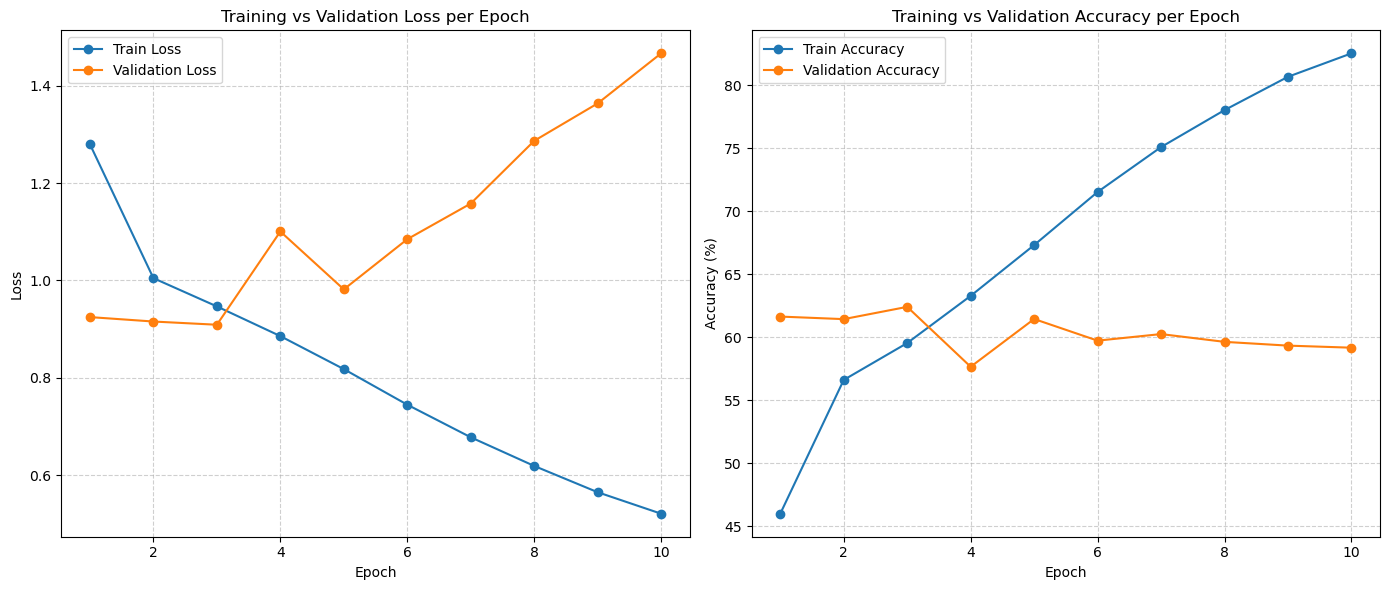

In [22]:
# Visualize training and validation loss and accuracy trends

plt.figure(figsize=(14, 6))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(df["epoch"], df["train_loss"], label="Train Loss", marker='o')
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(df["epoch"], df["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(df["epoch"], df["val_accuracy"], label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

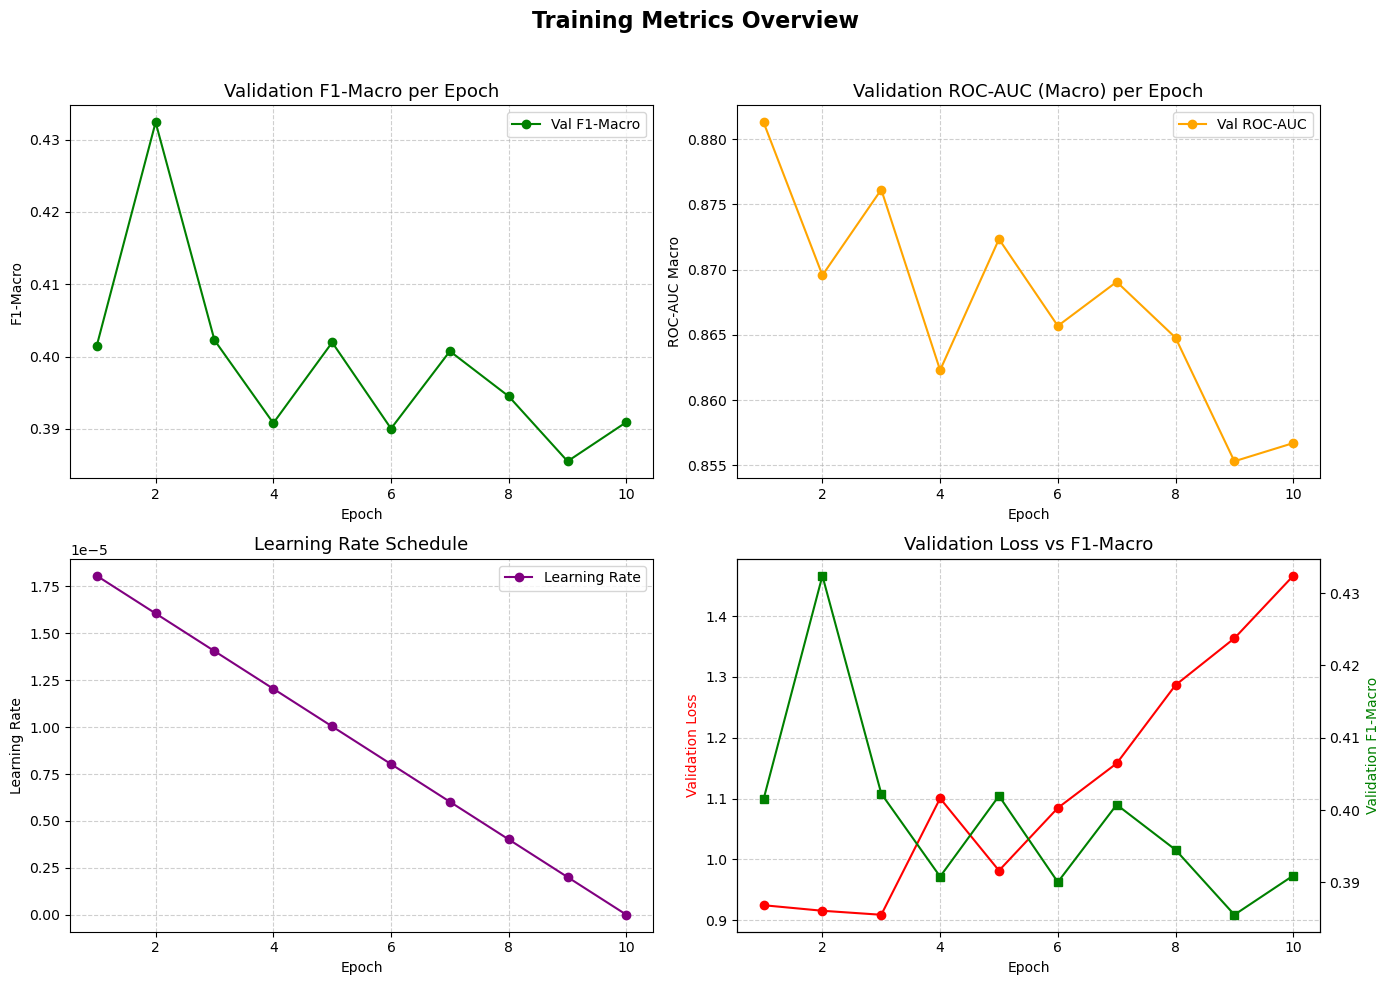

In [23]:
import matplotlib.pyplot as plt

# Membuat subplot tambahan untuk metrik lain
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- F1-Macro ---
axes[0, 0].plot(df["epoch"], df["val_f1_macro"], marker='o', color='green', label="Val F1-Macro")
axes[0, 0].set_title("Validation F1-Macro per Epoch", fontsize=13)
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("F1-Macro")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.6)

# --- ROC-AUC ---
axes[0, 1].plot(df["epoch"], df["val_roc_auc_macro"], marker='o', color='orange', label="Val ROC-AUC")
axes[0, 1].set_title("Validation ROC-AUC (Macro) per Epoch", fontsize=13)
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("ROC-AUC Macro")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.6)

# --- Learning Rate Schedule ---
axes[1, 0].plot(df["epoch"], df["learning_rate"], marker='o', color='purple', label="Learning Rate")
axes[1, 0].set_title("Learning Rate Schedule", fontsize=13)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Learning Rate")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.6)

# --- Val Loss vs F1 ---
ax2 = axes[1, 1].twinx()
axes[1, 1].plot(df["epoch"], df["val_loss"], marker='o', color='red', label="Val Loss")
ax2.plot(df["epoch"], df["val_f1_macro"], marker='s', color='green', label="Val F1-Macro")
axes[1, 1].set_title("Validation Loss vs F1-Macro", fontsize=13)
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Validation Loss", color='red')
ax2.set_ylabel("Validation F1-Macro", color='green')
axes[1, 1].grid(True, linestyle="--", alpha=0.6)

fig.suptitle("Training Metrics Overview", fontsize=16, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


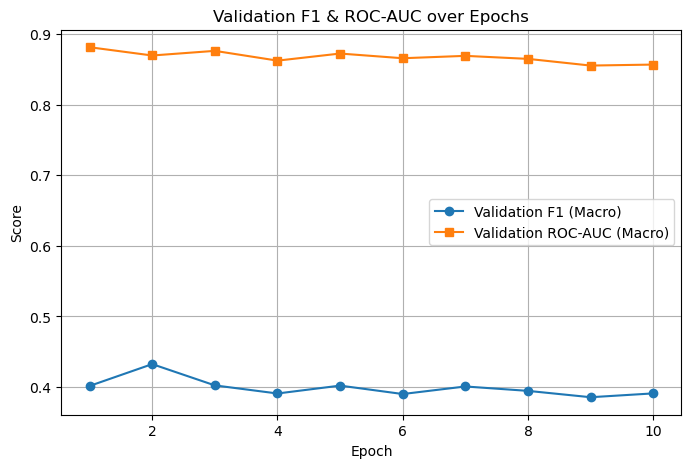

In [24]:
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['val_f1_macro'], label='Validation F1 (Macro)', marker='o')
plt.plot(df['epoch'], df['val_roc_auc_macro'], label='Validation ROC-AUC (Macro)', marker='s')
plt.title('Validation F1 & ROC-AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()